In [1]:
# Only run once, unless restarting kernel
import os
os.chdir('../')
print(os.getcwd())  # Should output the project folder

/home/vlad/Desktop/lmu_bachelor_thesis/code/VariationalInformationPursuit


In [2]:
import torch
from arch.mutagenicity import QuerierMutagenicity, ClassifierMutagenicity

import mutagenicity_utils
import numpy as np
import ops
import torch.nn.functional as F
from main_mutagenicity import evaluate

/home/vlad/anaconda3/envs/vip_graphs/lib/python3.12/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1729805341246/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('DEVICE:', device)

DEVICE: cpu


In [4]:
classifier = ClassifierMutagenicity(queryset_size=403).to(device)
querier = QuerierMutagenicity(queryset_size=403, tau=1.0).to(device)

In [5]:
PATH = './saved/y3fy898v/ckpt/epoch99.ckpt' 
ckpt = torch.load(PATH, weights_only=True, map_location=device)

Since the model was trained with nn.DataParallel, and we called model.state_dict() in torch.save() instead of model.module.state_dict(), we still have that "module." wrapper in from of the keys of the state_dict. Next time, save the state_dict correctly, but for now, we must remove the wrapper from the key names.

In [6]:
from collections import OrderedDict

# Classifier
state_dict = ckpt['classifier']
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    # Remove the 'module.' prefix if it exists
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

classifier.load_state_dict(new_state_dict)

# Querier
state_dict = ckpt['querier']
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    # Remove the 'module.' prefix if it exists
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

querier.load_state_dict(new_state_dict)

<All keys matched successfully>

Load Mutagenicity dataset and queryset.

In [7]:
from dataset import load_mutagenicity_dataset, load_mutagenicity_queryset

dataset_root = './data/Mutagenicity'
queryset_root = './experiments/rdkit_querysets/queryset_1.csv'

dataset = load_mutagenicity_dataset(dataset_root)
qry_ans_set = load_mutagenicity_queryset(dataset_root, queryset_root, train_ratio=None)

Loading and processing Mutagenicity dataset for training...


100%|██████████| 4337/4337 [00:03<00:00, 1194.49it/s]


Loading complete.


# Single Sample Posterior Probability Heatmap

In [38]:
idx = 2222
# Good examples: 2000
data = dataset[idx]
qry_ans = qry_ans_set[idx]

test_features = qry_ans[0].unsqueeze(0)  # (1, N_QUERIES)
test_labels = qry_ans[1].unsqueeze(0)  # (1)
test_sample_id = qry_ans[2].unsqueeze(0)  # (1)

test_features = test_features.to(device)
test_labels = test_labels.to(device)

print(test_features.shape)
print(test_labels.shape)
print(test_sample_id)

torch.Size([1, 403])
torch.Size([1])
tensor([2222])


In [39]:
G = mutagenicity_utils.raw_to_nx(data)
mol = mutagenicity_utils.nx_to_rdkit(G)

Set evaluation parameters.

In [40]:
N_QUERIES = 403
max_queries_test = 20
THRESHOLD = 0.8

In [41]:
params = {
    'test_features': test_features,
    'querier': querier,
    'classifier': classifier,
    'n_queries': N_QUERIES,
    'max_queries_test': max_queries_test,
}
logits, queries = evaluate(**params)

In [42]:
# prediction using all queries (last query?)
test_pred_max = logits[:, -1, :].argmax(dim=1).float()  # Why are we taking the last query logits always?
# test_acc_max = (test_pred_max == test_labels.squeeze()).float().sum()

# compute number of queries needed for prediction
qry_need = ops.compute_queries_needed(logits, threshold=THRESHOLD)

# prediction using IP
test_pred_ip = logits[torch.arange(len(qry_need)), qry_need-1].argmax(1)
# test_acc_ip = (test_pred_ip == test_labels.squeeze()).float().sum()

print(test_pred_max)
print(test_pred_ip)

tensor([1.])
tensor([1])


In [43]:
# Get query answer pairs that querier produced, but in natural language that 
q_ans_pairs = []
for q in queries[0]:
    q_idx = torch.argmax(q).item()
    q_name = mutagenicity_utils.get_query_name_list()[q_idx]
    q_ans = qry_ans[0][q_idx].item()
    q_ans_pairs.append((q_name, q_ans))

q_ans_pairs

[('COO=0', 1),
 ('NH0=0', 1),
 ('ArN=0', 1),
 ('benzene=1', 1),
 ('ester=0', 1),
 ('alkyl_halide=0', 1),
 ('bicyclic=0', 1),
 ('Ndealkylation2=0', 1),
 ('nitroso=0', 1),
 ('halogen=0', 1),
 ('benzene=0', -1),
 ('bicyclic=1', -1),
 ('benzene=4', -1),
 ('nitrile=0', 1),
 ('Ar_OH=0', 1),
 ('aniline=1', -1),
 ('C_O_noCOO=1', -1),
 ('sulfonamd=0', 1),
 ('Al_COO=0', 1),
 ('Ar_N=0', 1)]

In [44]:
# Get the functional groups and their counts present in the sample, in natural language
all_frag_counts = mutagenicity_utils.onehot_to_interpretable_dict(qry_ans[0])
frag_count_list = []
for frag, count in all_frag_counts.items():
    if count > 0:
        frag_count_list.append((frag, count))

frag_count_list

[('benzene', 1), ('epoxide', 1), ('ether', 2), ('methoxy', 1)]

Posterior Probability Heatmap (like Figure 3b and 3c in paper)

In [45]:
logits

tensor([[[ 0.1618, -0.1743],
         [-0.0576,  0.0394],
         [-0.1938,  0.1752],
         [-0.4484,  0.4410],
         [-0.3185,  0.3143],
         [-0.4435,  0.4471],
         [-0.5288,  0.5184],
         [-0.2977,  0.2744],
         [-0.4880,  0.4649],
         [-0.5445,  0.5152],
         [-0.5725,  0.5400],
         [-0.3995,  0.3616],
         [-0.5702,  0.5452],
         [-0.4685,  0.4487],
         [-0.4319,  0.4158],
         [-0.6258,  0.6065],
         [-0.6442,  0.6219],
         [-0.4653,  0.4326],
         [-0.4808,  0.4444],
         [-0.4494,  0.4107]]])

In [46]:
probs = F.softmax(logits, dim=2)
probs

tensor([[[0.5832, 0.4168],
         [0.4758, 0.5242],
         [0.4088, 0.5912],
         [0.2912, 0.7088],
         [0.3469, 0.6531],
         [0.2910, 0.7090],
         [0.2597, 0.7403],
         [0.3608, 0.6392],
         [0.2783, 0.7217],
         [0.2574, 0.7426],
         [0.2474, 0.7526],
         [0.3184, 0.6816],
         [0.2469, 0.7531],
         [0.2855, 0.7145],
         [0.2999, 0.7001],
         [0.2258, 0.7742],
         [0.2199, 0.7801],
         [0.2895, 0.7105],
         [0.2839, 0.7161],
         [0.2973, 0.7027]]])

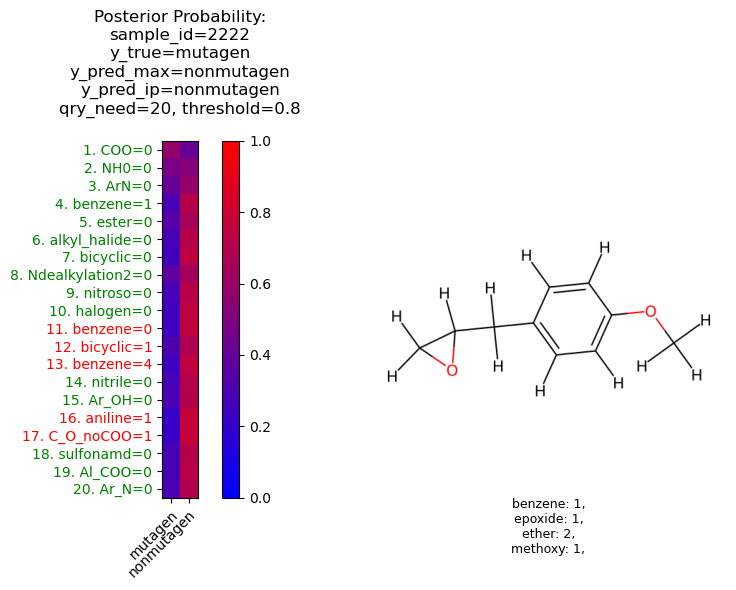

In [47]:
params = {
    'probs': probs[0],
    'queries': queries[0], 
    'answers': test_features[0], 
    'y_true': data.y.item(),
    'y_pred_max': test_pred_max.item(),
    'y_pred_ip': test_pred_ip.item(),
    'qry_need': qry_need.item(),
    'threshold': THRESHOLD,
    'sample_id': test_sample_id.item(),
    'mol': mol
}
fig, ax = mutagenicity_utils.create_posterior_prob_heatmap(**params);